In [52]:
!pip install yfinance pandas matplotlib pytz mplfinance

In [12]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pytz

In [53]:
def get_usd_jpy_window_data(start_date, end_date):
    # Define timezone
    sg_tz = pytz.timezone('Asia/Singapore')
    
    # Convert start and end dates to datetime objects
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    # Initialize an empty DataFrame to store results
    df_window = pd.DataFrame()
    
    # Loop through date range in 7-day chunks
    while start_date < end_date:
        # Define the end date for the current chunk
        chunk_end_date = min(start_date + timedelta(days=7), end_date)
        
        # Download USD/JPY data for the current chunk
        df_chunk = yf.download('JPY=X', start=start_date, end=chunk_end_date, interval='1m')
        
        # Convert index to Singapore time
        df_chunk.index = df_chunk.index.tz_convert(sg_tz)
        
        # Extract data between 8:45 AM and 9:05 AM
        df_chunk_window = df_chunk.between_time('08:55', '09:05')
        
        # Append the chunk to the results DataFrame
        df_window = pd.concat([df_window, df_chunk_window])
        
        # Update the start date for the next chunk
        start_date = chunk_end_date
    
    return df_window


In [54]:
# Define the end date as yesterday's date to avoid fetching today's incomplete data
end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=29)).strftime('%Y-%m-%d')  # 29 days before the end date

# Get the data for the specified time window
usd_jpy_window = get_usd_jpy_window_data(start_date, end_date)

# Display the first few rows of the dataframe
usd_jpy_window.head()



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2024-04-22 08:55:00+08:00,154.735992,154.735992,154.705994,154.718994,154.718994,0
2024-04-22 08:56:00+08:00,154.714996,154.718002,154.679993,154.692001,154.692001,0
2024-04-22 08:57:00+08:00,154.688004,154.692001,154.677994,154.684998,154.684998,0
2024-04-22 08:58:00+08:00,154.684006,154.701996,154.667999,154.667999,154.667999,0
2024-04-22 08:59:00+08:00,154.666000,154.673004,154.658997,154.669006,154.669006,0


In [55]:
# Calculate the direction (up or down) for each day
usd_jpy_window['Direction'] = usd_jpy_window['Close'].diff().apply(lambda x: 'Up' if x > 0 else 'Down')

# Group by date and determine if the day was 'Up' or 'Down'
usd_jpy_window['Date'] = usd_jpy_window.index.date
daily_direction = usd_jpy_window.groupby('Date')['Direction'].last()

# Function to calculate the percentage of 'Up' days in the last N days
def percentage_up_days(last_n_days):
    recent_days = daily_direction.tail(last_n_days)
    up_days = (recent_days == 'Up').sum()
    total_days = len(recent_days)
    return (up_days / total_days) * 100

# Calculate the percentages for the last 5, 10, 20, and 30 days
percentage_last_5_days = percentage_up_days(5)
percentage_last_10_days = percentage_up_days(10)
percentage_last_20_days = percentage_up_days(20)
percentage_last_30_days = percentage_up_days(30)

# Print the results
print(f"Percentage of 'Up' days in the last 5 days: {percentage_last_5_days}%")
print(f"Percentage of 'Up' days in the last 10 days: {percentage_last_10_days}%")
print(f"Percentage of 'Up' days in the last 20 days: {percentage_last_20_days}%")
print(f"Percentage of 'Up' days in the last 30 days: {percentage_last_30_days}%")



Percentage of 'Up' days in the last 5 days: 40.0%
Percentage of 'Up' days in the last 10 days: 60.0%
Percentage of 'Up' days in the last 20 days: 50.0%
Percentage of 'Up' days in the last 30 days: 50.0%


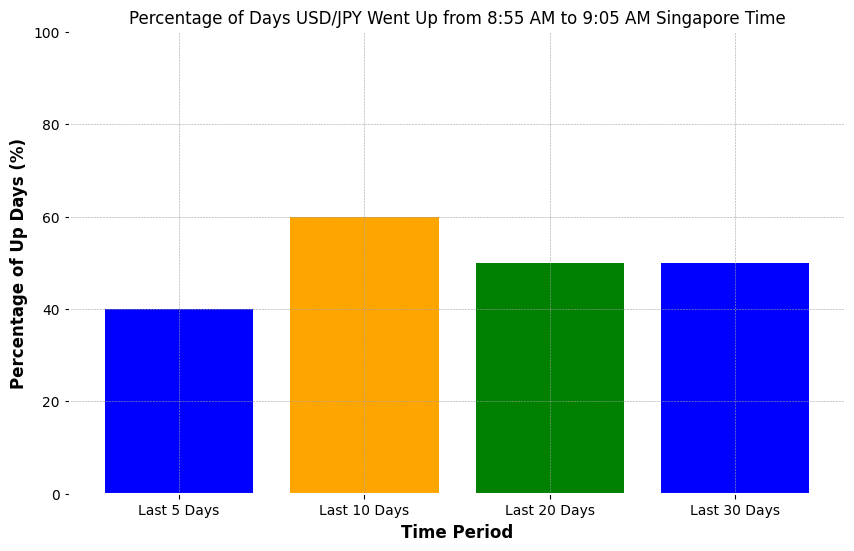

In [57]:
# Data for plotting
days = ['Last 5 Days', 'Last 10 Days', 'Last 20 Days', 'Last 30 Days']
percentages = [percentage_last_5_days, percentage_last_10_days, percentage_last_20_days, percentage_last_30_days]

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(days, percentages, color=['blue', 'orange', 'green'])
plt.xlabel('Time Period')
plt.ylabel('Percentage of Up Days (%)')
plt.title('Percentage of Days USD/JPY Went Up from 8:55 AM to 9:05 AM Singapore Time')
plt.ylim(0, 100)
plt.grid(True)
plt.show()



In [59]:
recent_history = daily_direction.tail(30)
print("Recent History (Last 30 Days):")
print(recent_history)


Recent History (Last 30 Days):
Date
2024-04-22    Down
2024-04-23    Down
2024-04-24      Up
2024-04-25      Up
2024-04-26    Down
2024-04-29      Up
2024-04-30      Up
2024-05-01    Down
2024-05-02    Down
2024-05-03    Down
2024-05-06    Down
2024-05-07      Up
2024-05-08      Up
2024-05-09      Up
2024-05-10      Up
2024-05-13    Down
2024-05-14      Up
2024-05-15    Down
2024-05-16      Up
2024-05-17    Down
Name: Direction, dtype: object


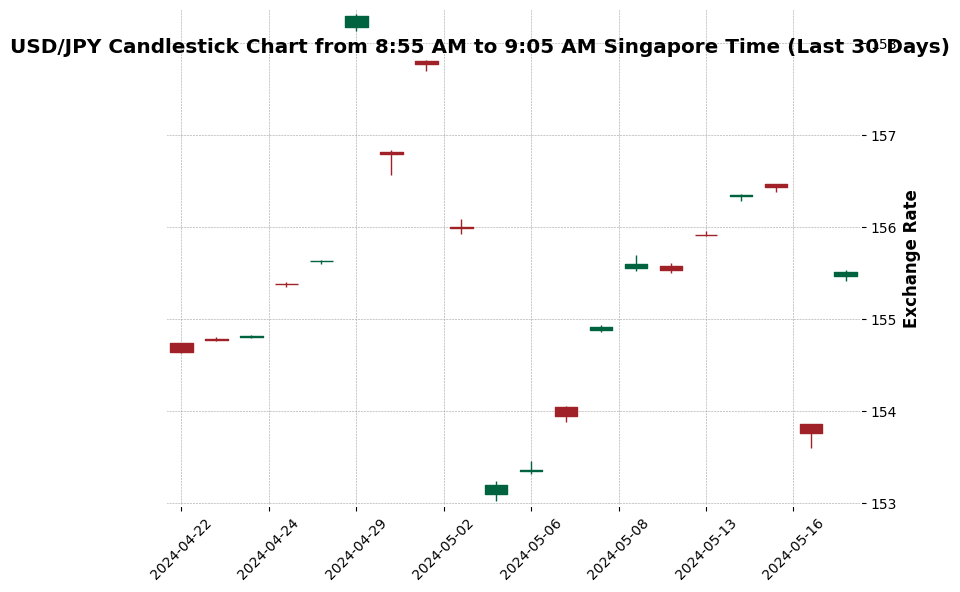

In [60]:
import mplfinance as mpf

# Ensure the DateTime index is properly set
usd_jpy_window.index.name = 'DateTime'

# Resample data to get OHLC (Open, High, Low, Close) for each day
ohlc_dict = {
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last'
}
usd_jpy_ohlc = usd_jpy_window.resample('D').apply(ohlc_dict).dropna()

# Select the last 30 days of data
usd_jpy_ohlc_last_30 = usd_jpy_ohlc.tail(30)

# Plot the data as candlestick chart
mpf.plot(usd_jpy_ohlc_last_30, type='candle', style='charles',
         title='USD/JPY Candlestick Chart from 8:55 AM to 9:05 AM Singapore Time (Last 30 Days)',
         ylabel='Exchange Rate', datetime_format='%Y-%m-%d',
         tight_layout=True)

